In [21]:
import pandas as pd
from anomaly_detection import detect_anomaly, loader
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [22]:
dir(detect_anomaly)

['AutoDiagonalNormal',
 'DataLoader',
 'IsolationForest',
 'KMeans',
 'Model',
 'NeuralNetwork',
 'OneClassSVM',
 'Predictive',
 'PyroModule',
 'PyroSample',
 'SVI',
 'ToTensor',
 'Trace_ELBO',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dist',
 'mixture',
 'nn',
 'np',
 'optimizeBNN',
 'optimizeNN',
 'partial',
 'pyro',
 'runGaussianMixture',
 'runIsolationForest',
 'runKMeans',
 'runOneClassSVM',
 'torch',
 'tqdm',
 'trange']

In [23]:
# !pip install git+https://github.com/kpapdac/anomaly_detection.git

In [24]:
donors = pd.read_csv(r'https://github.com/GuansongPang/ADRepository-Anomaly-detection-datasets/raw/main/numerical%20data/DevNet%20datasets/KDD2014_donors_10feat_nomissing_normalised.csv')

The donors data is taken from KDD Cup 2014 for predicting excitement of projects proposed by K-12 school teachers, in which
exceptionally exciting projects are used as anomalies (5.92% data).

In [25]:
donors.groupby('class')['fully_funded=t'].count()

class
0    582616
1     36710
Name: fully_funded=t, dtype: int64

In [26]:
donors.nunique()

at_least_1_teacher_referred_donor=t                   3
fully_funded=t                                        2
at_least_1_green_donation=0                           3
great_chat=t                                          2
three_or_more_non_teacher_referred_donors=0           3
one_non_teacher_referred_donor_giving_100_plus=t      3
donation_from_thoughtful_donor=t                      3
great_messages_proportion                           102
teacher_referred_count                               82
non_teacher_referred_count                          135
class                                                 2
dtype: int64

In [27]:
disc=4 # Disc(retization) may be between 2 and 9
r=np.array(range(disc+1))/(1.0*disc)
print(r)
# quantiles are building using pandas.qcut
# The "class" column is just copied.
l=[]
for col in donors.columns.values:
    if col in ['great_messages_proportion','non_teacher_referred_count']:
        l.append(pd.DataFrame(pd.qcut(donors[col],r),columns=[col]))
    else:
        l.append(pd.DataFrame(donors[col].astype(int),columns=[col]))
treated=pd.concat(l, join='outer', axis=1)

treated.head()

[0.   0.25 0.5  0.75 1.  ]


,at_least_1_teacher_referred_donor=t,fully_funded=t,at_least_1_green_donation=0,great_chat=t,three_or_more_non_teacher_referred_donors=0,one_non_teacher_referred_donor_giving_100_plus=t,donation_from_thoughtful_donor=t,great_messages_proportion,teacher_referred_count,non_teacher_referred_count,class
0,0,1,1,0,1,1,0,"(-0.001, 0.42]",0,"(-0.001, 0.00658]",0
1,1,1,0,0,0,0,0,"(0.42, 0.529]",0,"(0.0143, 1.0]",0
2,0,1,1,0,1,1,0,"(-0.001, 0.42]",0,"(-0.001, 0.00658]",0
3,0,0,1,0,1,1,0,"(0.42, 0.529]",0,"(-0.001, 0.00658]",0
4,0,1,0,0,1,1,0,"(0.42, 0.529]",0,"(-0.001, 0.00658]",0


Learned in 1035.774805ms


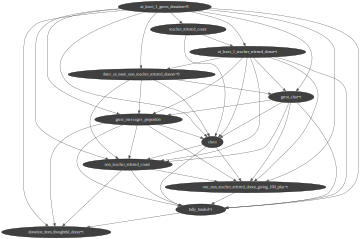

In [28]:
#we put the discretized values in a csv file in order to be learned by pyAgrum
treated.to_csv("donors_bn.csv",index=False)

learner=gum.BNLearner("donors_bn.csv")
learner.useLocalSearchWithTabuList()
bn_donors=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.showBN(bn_donors)

In [29]:
bn_donors.cpt('class')

(pyAgrum.Potential<double>@0x55d1b3f31630) 
                                         ||  class            |
three_|at_lea|teache|great_|great_|at_lea||0        |1        |
------|------|------|------|------|------||---------|---------|
0     |0     |0     |0     |(-0.00|0     || 1.0000  | 0.0000  |
1     |0     |0     |0     |(-0.00|0     || 1.0000  | 0.0000  |
0     |1     |0     |0     |(-0.00|0     || 1.0000  | 0.0000  |
1     |1     |0     |0     |(-0.00|0     || 1.0000  | 0.0000  |
0     |0     |1     |0     |(-0.00|0     || 0.5000  | 0.5000  |
1     |0     |1     |0     |(-0.00|0     || 0.5000  | 0.5000  |
[...116 more line(s) ...]
0     |1     |0     |1     |(0.66,|1     || 1.0000  | 0.0000  |
1     |1     |0     |1     |(0.66,|1     || 1.0000  | 0.0000  |
0     |0     |1     |1     |(0.66,|1     || 0.5000  | 0.5000  |
1     |0     |1     |1     |(0.66,|1     || 0.5000  | 0.5000  |
0     |1     |1     |1     |(0.66,|1     || 0.5000  | 0.5000  |
1     |1     |1     |1     |(0.66,|1     || 0.5000  | 0.5000  |

In [30]:
bn_donors.cpt('fully_funded=t')

(pyAgrum.Potential<double>@0x55d1b3efe2d0) 
                                                ||  fully_funded=t   |
at_lea|class |one_no|non_te|at_lea|great_|great_||0        |1        |
------|------|------|------|------|------|------||---------|---------|
0     |0     |0     |(-0.00|0     |(-0.00|0     || 0.6822  | 0.3178  |
1     |0     |0     |(-0.00|0     |(-0.00|0     || 0.8559  | 0.1441  |
0     |1     |0     |(-0.00|0     |(-0.00|0     || 0.5000  | 0.5000  |
1     |1     |0     |(-0.00|0     |(-0.00|0     || 0.5000  | 0.5000  |
0     |0     |1     |(-0.00|0     |(-0.00|0     || 0.0328  | 0.9672  |
1     |0     |1     |(-0.00|0     |(-0.00|0     || 0.0189  | 0.9811  |
[...500 more line(s) ...]
0     |1     |0     |(0.014|1     |(0.66,|1     || 0.0000  | 1.0000  |
1     |1     |0     |(0.014|1     |(0.66,|1     || 0.5000  | 0.5000  |
0     |0     |1     |(0.014|1     |(0.66,|1     || 1.0000  | 0.0000  |
1     |0     |1     |(0.014|1     |(0.66,|1     || 0.0420  | 0.9580  |
0     |1     |1     |(0.014|1     |(0.66,|1     || 0.0000  | 1.0000  |
1     |1     |1     |(0.014|1     |(0.66,|1     || 0.5000  | 0.5000  |

In [31]:
ie=gum.LazyPropagation(bn_donors)
ie.setEvidence({'great_messages_proportion': '(0.66, 1.0]'})
ie.makeInference()
ie.posterior("class")

(pyAgrum.Potential<double>@0x55d1b3f71460) 
  class            |
0        |1        |
---------|---------|
 0.8262  | 0.1738  |

In [32]:
bn_donors.parents('class')

{0, 2, 3, 4, 7, 8}

In [33]:
parents = treated.iloc[:,list(bn_donors.parents('class'))].columns
print(parents)

Index(['at_least_1_teacher_referred_donor=t', 'at_least_1_green_donation=0',
       'great_chat=t', 'three_or_more_non_teacher_referred_donors=0',
       'great_messages_proportion', 'teacher_referred_count'],
      dtype='object')


Sample stratification

In [58]:
donors

,at_least_1_teacher_referred_donor=t,fully_funded=t,at_least_1_green_donation=0,great_chat=t,three_or_more_non_teacher_referred_donors=0,one_non_teacher_referred_donor_giving_100_plus=t,donation_from_thoughtful_donor=t,great_messages_proportion,teacher_referred_count,non_teacher_referred_count,class,cross_mess_ref
0,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.000000,0.000000,0.003289,0,0.000000
1,1.00000,1,0.000000,0,0.000000,0.000000,0.000000,0.500000,0.026490,0.029605,0,0.000000
2,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.000000,0.000000,0.003289,0,0.000000
3,0.00000,0,1.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.006579,0,0.529271
4,0.00000,1,0.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.003289,0,0.529271
...,...,...,...,...,...,...,...,...,...,...,...,...
619321,0.00000,0,1.000000,1,1.000000,0.000000,0.000000,1.000000,0.000000,0.006579,0,1.000000
619322,0.00000,0,1.000000,0,0.000000,0.000000,0.000000,0.250000,0.000000,0.016447,0,0.000000
619323,0.23748,0,0.278581,0,0.481114,0.719735,0.013213,0.529271,0.005148,0.014346,0,0.254640
619324,0.23748,0,0.278581,0,0.481114,0.719735,0.013213,0.529271,0.005148,0.014346,0,0.254640


In [66]:
donors.loc[:,'cross_mess_ref'] = donors['great_messages_proportion'] * donors['three_or_more_non_teacher_referred_donors=0']
X = donors.iloc[0:5000,list(bn_donors.parents('class'))+[11]].copy().to_numpy()
y = donors.iloc[0:5000,donors.shape[1]-2:donors.shape[1]-1].copy().to_numpy()
groups = donors.iloc[0:5000,donors.shape[1]-2:donors.shape[1]-1].copy().to_numpy()
gss = GroupShuffleSplit(n_splits=2, train_size=1, random_state=42)
X_train_twoclass = []
y_train_twoclass = []
for i, (train_index, test_index) in enumerate(gss.split(X, y,groups)):
    print(f"Fold {i}:")
    print(len(groups[train_index]))
    X_train = X[train_index]
    y_train = y[train_index]
    X_train_twoclass.append(X_train)
    y_train_twoclass.append(y_train)
print(np.concatenate([X_train_twoclass[0],X_train_twoclass[1]]).shape)
X_train_m = np.concatenate([X_train_twoclass[0],X_train_twoclass[1]])
y_train_m = np.concatenate([y_train_twoclass[0],y_train_twoclass[1]])

Fold 0:
4694
Fold 1:
306
(5000, 7)


OneClassSVM, Isolation Forest, Kmeans, Gaussian MM

In [67]:
X = X_train_m.copy()
pred_svm = detect_anomaly.runOneClassSVM().fit_predict(X,X)
pred_if = detect_anomaly.runIsolationForest().fit_predict(X,X)
pred_km = detect_anomaly.runKMeans(2).fit_predict(X,X)
pred_gmm = detect_anomaly.runGaussianMixture(2).fit_predict(X,X)

In [68]:
(pred_svm==1).sum(),(pred_svm==-1).sum(), (pred_if==1).sum(),(pred_if==-1).sum(), (pred_km==1).sum(),(pred_km==0).sum(), (pred_gmm[0]==1).sum(),(pred_gmm[0]==0).sum()

(2906, 2094, 1910, 3090, 3439, 1561, 2219, 2781)

Deep Learning

In [69]:
nn_model = detect_anomaly.NeuralNetwork(D_in=X.shape[1],H=2)
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y[:,0])
# x = torch.randn(128, 20)
# y = torch.from_numpy(np.repeat(0,128))
X_y = [(x[i],y[i]) for i in range(len(x))]
dataset_ = loader.FeatureClusterDataset(X_y)
train_dataloader = DataLoader(dataset_, batch_size=64)
opt = detect_anomaly.optimizeNN(train_dataloader, nn_model, learning_rate=1e-3, batch_size=64, epochs=5)
opt.train_loop()
opt.iterate()

tensor([-0.1350,  0.1773], grad_fn=<SliceBackward0>)
loss: 0.510062  [   64/ 5000]
tensor([ 0.4008, -0.3680], grad_fn=<SliceBackward0>)
tensor([ 0.3635, -0.0217], grad_fn=<SliceBackward0>)
tensor([ 0.4746, -0.4211], grad_fn=<SliceBackward0>)
tensor([ 0.3517, -0.3334], grad_fn=<SliceBackward0>)
tensor([ 0.2720, -0.1192], grad_fn=<SliceBackward0>)
tensor([ 0.4766, -0.4230], grad_fn=<SliceBackward0>)
tensor([ 0.2883, -0.2368], grad_fn=<SliceBackward0>)
tensor([ 0.4536, -0.1136], grad_fn=<SliceBackward0>)
tensor([ 0.2177, -0.1918], grad_fn=<SliceBackward0>)
tensor([-0.1281,  0.1705], grad_fn=<SliceBackward0>)
tensor([ 0.2906, -0.2391], grad_fn=<SliceBackward0>)
tensor([0.4499, 0.0288], grad_fn=<SliceBackward0>)
tensor([ 0.2773, -0.1245], grad_fn=<SliceBackward0>)
tensor([0.0308, 0.0908], grad_fn=<SliceBackward0>)
tensor([-0.0881, -0.1118], grad_fn=<SliceBackward0>)
tensor([ 0.5096, -0.4394], grad_fn=<SliceBackward0>)
tensor([ 0.1117, -0.1246], grad_fn=<SliceBackward0>)
tensor([0.4549, 0.02

tensor([ 0.1689, -0.0517], grad_fn=<SliceBackward0>)
tensor([ 0.5391, -0.1973], grad_fn=<SliceBackward0>)
tensor([ 0.1701, -0.0529], grad_fn=<SliceBackward0>)
tensor([ 0.7954, -0.5503], grad_fn=<SliceBackward0>)
tensor([ 0.7563, -0.5215], grad_fn=<SliceBackward0>)
tensor([ 0.7421, -0.2088], grad_fn=<SliceBackward0>)
tensor([ 0.7032, -0.4803], grad_fn=<SliceBackward0>)
tensor([ 0.7423, -0.4876], grad_fn=<SliceBackward0>)
Epoch 3
-------------------------------
tensor([-0.0003,  0.0426], grad_fn=<SliceBackward0>)
loss: 0.424808  [   64/ 5000]
tensor([ 0.5180, -0.4852], grad_fn=<SliceBackward0>)
tensor([ 0.5439, -0.2021], grad_fn=<SliceBackward0>)
tensor([ 0.5985, -0.5449], grad_fn=<SliceBackward0>)
tensor([ 0.4637, -0.4454], grad_fn=<SliceBackward0>)
tensor([ 0.4080, -0.2552], grad_fn=<SliceBackward0>)
tensor([ 0.6000, -0.5465], grad_fn=<SliceBackward0>)
tensor([ 0.4094, -0.3578], grad_fn=<SliceBackward0>)
tensor([ 0.6009, -0.2609], grad_fn=<SliceBackward0>)
tensor([ 0.3372, -0.3113], gr

tensor([ 0.5486, -0.5303], grad_fn=<SliceBackward0>)
tensor([ 0.3641, -0.5120], grad_fn=<SliceBackward0>)
tensor([ 0.1072, -0.0649], grad_fn=<SliceBackward0>)
tensor([ 0.5206, -0.2555], grad_fn=<SliceBackward0>)
tensor([ 0.5135, -0.3607], grad_fn=<SliceBackward0>)
tensor([ 0.5031, -0.4516], grad_fn=<SliceBackward0>)
tensor([ 0.0783, -0.2782], grad_fn=<SliceBackward0>)
tensor([ 0.5038, -0.4523], grad_fn=<SliceBackward0>)
tensor([ 0.3020, -0.1848], grad_fn=<SliceBackward0>)
tensor([ 0.6872, -0.3453], grad_fn=<SliceBackward0>)
tensor([ 0.3031, -0.1859], grad_fn=<SliceBackward0>)
tensor([ 0.9081, -0.6630], grad_fn=<SliceBackward0>)
tensor([ 0.8660, -0.6313], grad_fn=<SliceBackward0>)
tensor([ 0.9004, -0.3670], grad_fn=<SliceBackward0>)
tensor([ 0.8088, -0.5858], grad_fn=<SliceBackward0>)
tensor([ 0.8498, -0.5950], grad_fn=<SliceBackward0>)
Done!


In [70]:
logits = nn_model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

In [71]:
(y_pred==y).sum(), (y_pred!=y).sum(), ((y_pred!=y) & (y_pred==1)).sum(), ((y_pred==y) & (y_pred==1)).sum(), (y_pred==1).sum(), (y_pred==0).sum()

(tensor(4694), tensor(306), tensor(0), tensor(0), tensor(0), tensor(5000))

In [72]:
from sklearn import metrics
scores = pred_probab[:,1].detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(y.detach().numpy(), scores, pos_label=1)

In [73]:
pred_probab[:,1].detach().numpy().shape, y.detach().numpy().shape

((5000,), (5000,))

In [74]:
metrics.auc(fpr, tpr)

0.5213598363645984

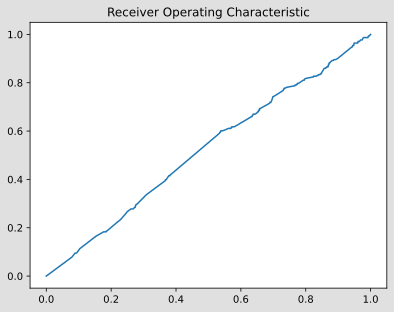

In [75]:
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)

In [76]:
print(f"Model structure: {nn_model}\n\n")

for name, param in nn_model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Linear(in_features=7, out_features=2, bias=True)
)


Layer: linear_relu_stack.weight | Size: torch.Size([2, 7]) | Values : tensor([[ 0.2114, -0.2017, -0.0089,  0.0311,  0.4253,  0.0359, -0.0399],
        [-0.0204,  0.1704,  0.1275,  0.2112, -0.3217,  0.0466,  0.0859]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.bias | Size: torch.Size([2]) | Values : tensor([ 0.2820, -0.4507], grad_fn=<SliceBackward0>) 



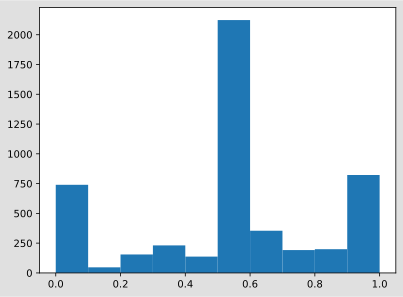

In [45]:
plt.hist(X[:,-2]);

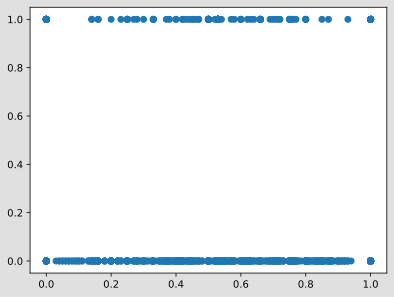

In [47]:
plt.scatter(X[:,-2],y)